## COVID19 CLASSIFICATION

###### This is a research project to analyse feasibility of putting efficient deep learning models in production for screening COVID19 samples  as fast and precise as possible.

##### dataset credits: https://www.kaggle.com/darshan1504/covid19-detection-xray-dataset

###### Group all non-covid19 data as negative and remaining covid19 data as positive in covid19-detection-xray-dataset/NonAugmentedTrain directory and similarly in covid19-detection-xray-dataset/ValData directory

In [1]:
!nvidia-smi

Tue Mar 24 10:25:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0  On |                  N/A |
| 11%   43C    P8     4W / 250W |    341MiB / 11016MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### If using TF2.0 run the below cell else import TF normally

In [2]:
import tensorflow.compat.v1 as tf
print(tf.__version__)
tf.disable_v2_behavior()
print(tf.test.gpu_device_name())

2.1.0
Instructions for updating:
non-resource variables are not supported in the long term
/device:GPU:0


In [26]:

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from glob import glob
import os
import cv2
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import Sequence 
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
import albumentations as albu
from sklearn.metrics import confusion_matrix as cm
from model import build_model
import pickle
from shutil import move,copy

def plot_bar(data,text=None):
  unq,counts= np.unique(data,return_counts=True)
  print('unique :{} counts :{}'.format(unq,counts))
  if text!=None:
    plt.title(text)
  plt.bar(unq,height=counts,tick_label=['noncovid19','covid19'])
  plt.show()  


#### load train-val and test filenames

#### I have clustered all non-covid x-ray samples as negative and remaining as positive samples

In [7]:
seed=23
np.random.seed(seed)
files=sorted(glob('covid19-detection-xray-dataset/NonAugmentedTrain/*/*/*.jpeg'))
test_files=sorted(glob('covid19-detection-xray-dataset/ValData/*/*/*.jpeg'))
print('num train-val files: ',len(files))
print('num test files: ',len(test_files))
files=shuffle(files)
nclasses=2
size=(224,224,3)
width=size[0]
height=size[1]
depth=size[2]
batch_size=8
class_names=['negative','positive']

num train-val files:  2002
num test files:  988


In [8]:
K.clear_session()

base_model=build_model(image_size=size,redux=1.0)
inputs=base_model.inputs
x=base_model.layers[-1].output
x=GlobalAveragePooling2D()(x)
if nclasses>1:
  act='softmax'
else:
  act='sigmoid'
outputs=Dense(nclasses,activation=act,name='final_'+act)(x)
model=Model(inputs,outputs)
print (model.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 112, 112, 16) 64          conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 16) 0           bn1[0][0]                        
____________________________________________________________________________________________

#### visualize the training and validation data distribution across classes

unique :[0 1] counts :[1942   60]


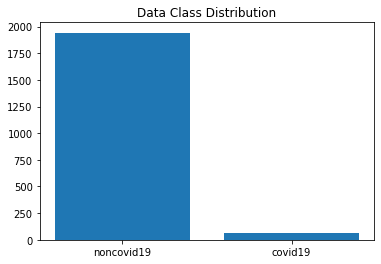

In [29]:
labels=[]
for file_ in files:
  if class_names[0] in file_:
    labels.append(0)

  if class_names[1] in file_:
    labels.append(1)



labels=np.array(labels)
plot_bar(labels,text='Data Class Distribution')

unique :[0 1] counts :[1554   48]


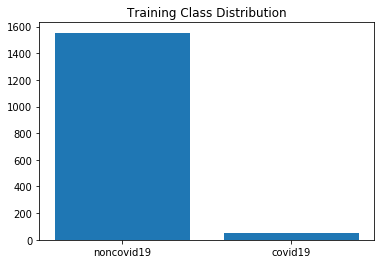

unique :[0 1] counts :[388  12]


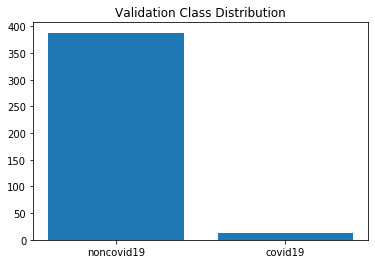

In [30]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X=files,y=labels)
for train_index, val_index in skf.split(files, labels):
  #print(train_index,val_index)
  train_files=[files[i] for i in train_index]
  train_labels=[labels[i] for i in train_index]
  val_files=[files[i] for i in val_index]
  val_labels=[labels[i] for i in val_index]

plot_bar(train_labels,text='Training Class Distribution')
plot_bar(val_labels,text='Validation Class Distribution')

#### I'm using custom datagenerator to add augmentation and other utilties currently not supported by frameworks . you can use  keras datgenerators like flow_from_directory if required

In [33]:
class_idx=-3

class datagen(Sequence):
  def __init__(self,train_im_path,normalize_img,augmentations,batch_size,img_size=256,nchannels=3,shuffle=True,verbose=False):
    self.batch_size=batch_size
    self.train_im_paths=train_im_path
    ## maps bw 0-1
    self.normalize_img=normalize_img
    self.img_size=img_size
    self.nchannels=nchannels
    self.shuffle=shuffle
    self.labels=class_names
    self.augmentations=augmentations
    print(self.augmentations)
    self.verbose=verbose
    self.on_epoch_end()
    print('Num images found : {}'.format(len(self.train_im_paths)))
    print('classes_found:{}'.format(self.labels))

  def __len__(self):
    return int(np.ceil(len(self.train_im_paths) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

    list_IDs_im = [self.train_im_paths[k] for k in indexes]
    
    X= self.data_generation(list_IDs_im,'rgb')
    y= self.label_generation(list_IDs_im)

    if self.augmentations==None:
      if self.normalize_img:
        return self.normalize(X),y
      return X,y
    else:
      im= []
      for x in X:
        augmented = self.augmentations(image=x)
        im.append(augmented['image'])
      if self.normalize_img:
        return self.normalize(im),y
      else:
        return np.array(im),y
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.train_im_paths))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def data_generation(self,list_IDs,color_mode):

    X = np.empty((len(list_IDs),self.img_size,self.img_size, self.nchannels))

    for count,i in enumerate(list_IDs):
      x=img_to_array(load_img(path=i,target_size=(self.img_size,self.img_size),color_mode=color_mode))
      x=np.expand_dims(x,axis=0)
      X[count]=x
    return np.uint8(X)

  def label_generation(self,list_IDs):
    one_hot=np.zeros((len(list_IDs),len(self.labels)))
    for count,i in enumerate(list_IDs):
      id_=i.split('/')[class_idx]
      if self.verbose:
        print(i,id_)
      if id_ in self.labels:
        idx=self.labels.index(id_)
        one_hot[count][idx]=1.0
      else:
        raise ValueError
    return one_hot

  
  def normalize(self,x):
    return np.array(x,dtype=np.float32)/255.0


#### some off-the shelf augmentations from awesome albumentations library. Make sure you don't lose trivial features when using augmentations 

In [34]:

AUGMENTATIONS_TRAIN= albu.Compose([
        albu.Flip(),
        albu.RandomBrightnessContrast(),            
        albu.OneOf([
            albu.IAAAdditiveGaussianNoise(),
            albu.GaussNoise(),
        ], p=0.2),
        albu.OneOf([
            albu.MotionBlur(p=.2),
            albu.MedianBlur(blur_limit=3, p=0.1),
            albu.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        albu.ShiftScaleRotate(shift_limit=0.0001, scale_limit=0.001, rotate_limit=45,border_mode=0),
        albu.OneOf([
            albu.OpticalDistortion(p=0.3),
            albu.GridDistortion(p=.1),
            albu.IAAPiecewiseAffine(p=0.3),
            albu.ElasticTransform(p=0.3)
        ], p=0.3),

    ], p=1.0)

AUGMENTATIONS_VAL=None

In [35]:
gen=datagen(train_files,False,None,batch_size,width,3,False)
aug_gen=datagen(train_files,False,AUGMENTATIONS_TRAIN,batch_size,width,3,True,False)
valgen=datagen(val_files,False,AUGMENTATIONS_VAL,len(val_files),width,3,True,False)
testgen=datagen(test_files,False,None,len(val_files),width,3,True,False)

None
Num images found : 1602
classes_found:['negative', 'positive']
Compose([
  Flip(always_apply=False, p=0.5),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  OneOf([
    IAAAdditiveGaussianNoise(always_apply=False, p=0.5, loc=0, scale=(2.5500000000000003, 12.75), per_channel=False),
    GaussNoise(always_apply=False, p=0.5, var_limit=(10.0, 50.0)),
  ], p=0.2),
  OneOf([
    MotionBlur(always_apply=False, p=0.2, blur_limit=(3, 7)),
    MedianBlur(always_apply=False, p=0.1, blur_limit=(3, 3)),
    Blur(always_apply=False, p=0.1, blur_limit=(3, 3)),
  ], p=0.2),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(-0.0001, 0.0001), scale_limit=(-0.0010000000000000009, 0.0009999999999998899), rotate_limit=(-45, 45), interpolation=1, border_mode=0, value=None, mask_value=None),
  OneOf([
    OpticalDistortion(always_apply=False, p=0.3, distort_limit=(-0.05, 0.05), shift_limit=(-0.05, 0.05), 

index: 73
(8, 224, 224, 3) (8, 2)


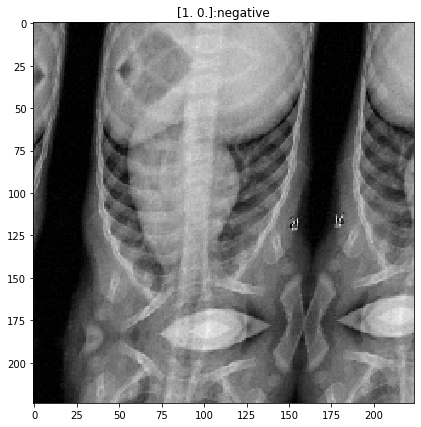

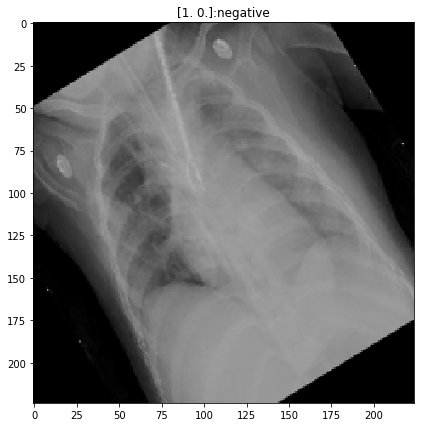

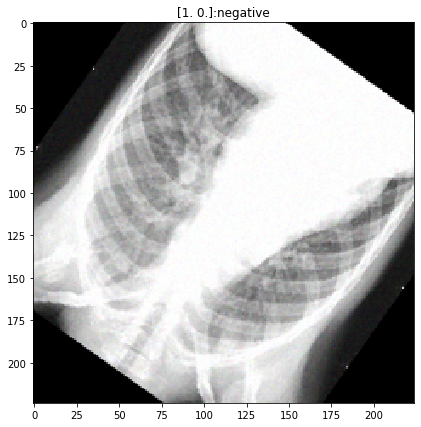

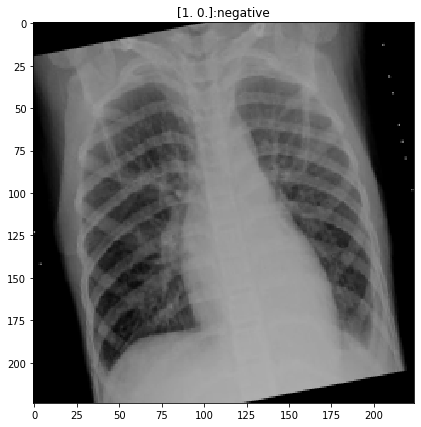

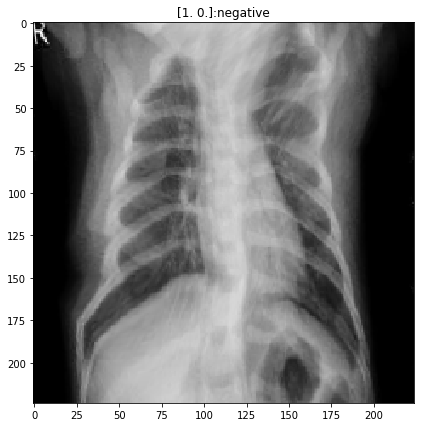

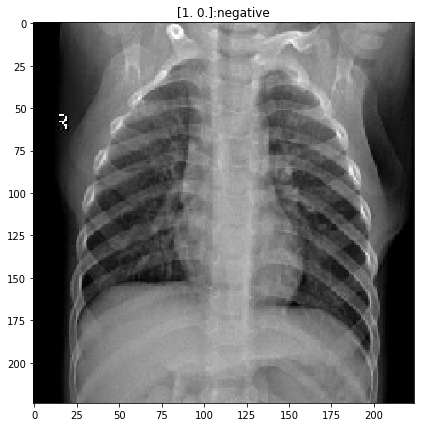

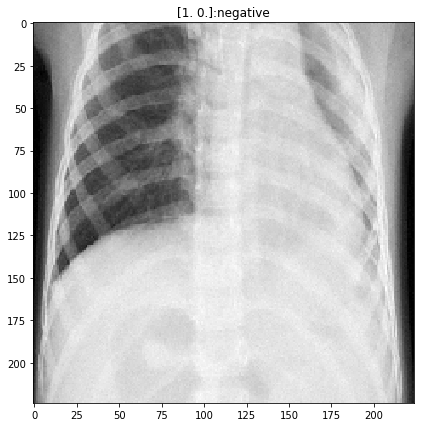

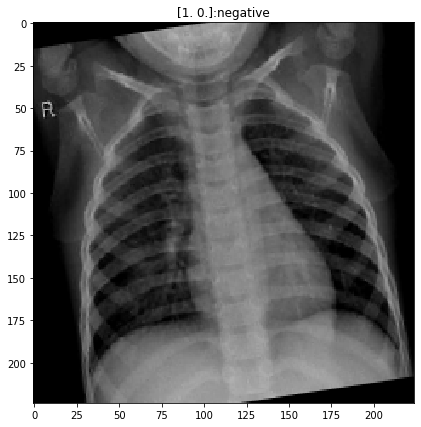

In [36]:
id=np.random.randint(0,len(aug_gen))
print('index:',id)
augimg,auglab=aug_gen[id]
print(augimg.shape,auglab.shape)
for i in range(len(augimg)):
  fig,ax=plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(7,7))
  #ax[0].title.set_text(str(lab[i])+':{}'.format(gen.labels[np.argmax(lab[i])]))
  #ax[0].imshow(img[i])
  ax.title.set_text(str(auglab[i])+':{}'.format(aug_gen.labels[np.argmax(auglab[i])]))
  ax.imshow(augimg[i])

In [ ]:
id=np.random.randint(0,len(valgen))
print('index:',id)
img,lab=valgen[id]
print(img.shape,lab.shape,img.dtype,lab.dtype)
for i in range(len(img)):
  fig,ax=plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(7,7))
  ax.title.set_text(str(lab[i]))
  ax.title.set_text(str(lab[i])+':{}'.format(valgen.labels[np.argmax(lab[i])]))
  ax.imshow(img[i])

In [40]:

metrics = [tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalseNegatives(name='fn'),
           tf.keras.metrics.FalsePositives(name='fp'),'accuracy',tf.keras.metrics.AUC(name='auc')]
           
#optimizer=Adam(lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=metrics)

#### model selectivity is an art when it comes to deep learning . A callback is required to select model checkpoints which performs well on test set. Here i'm selecting a model that predicts 9 out of 9 covid19 samples correctly and 985 out of 988 total samples correctly. As a result we can expect the model to generalize well on both covid19 and non-covid19 samples 

In [39]:
!mkdir models

class COVID(tf.keras.callbacks.Callback):
    
    def __init__(self):
        super(COVID, self).__init__()
        
   
    def on_epoch_end(self, epoch, logs=None):
        gt=[]
        pr=[]
        for id_ in range(len(testgen)):
              img,lab=testgen[id_]
              for i in range(len(img)):
                pr.append(np.argmax(np.squeeze(model.predict(np.expand_dims(img[i],axis=0)))))
                gt.append(np.argmax(lab[i]))

        gt=np.array(gt)
        pr=np.array(pr)
        cmat=cm(gt,pr)
        print('covid19 test samples {} correct out if 9 \n'.format(cmat[-1,-1]))
        print('samples correct {} out of {}  \n'.format((np.eye(cmat.shape[0])*cmat).sum().astype(np.int32),cmat.sum()))
        if cmat[-1,-1]==9 and int((np.eye(cmat.shape[0])*cmat).sum())>985 :
            model.save('models/covid19_test_{}_9_{}_988.h5'.format(cmat[-1,-1],(np.eye(cmat.shape[0])*cmat).sum().astype(np.int32)),include_optimizer=False)
        
       

mkdir: cannot create directory ‘models’: File exists


In [ ]:
initial_epoch=0
final_epoch=100
callbacks = [COVID()]
print ('batch_size:',batch_size)
history = model.fit_generator(
      aug_gen,
      steps_per_epoch=len(aug_gen),
      validation_data=valgen,
      validation_steps=len(valgen),
      epochs=final_epoch,
      callbacks=callbacks,
      verbose=1,initial_epoch=initial_epoch)

#### Now we can load our best model and plot the confusion matrix 

#### metrics and confusion matrix of validation data

In [44]:
K.clear_session()
model=load_model('models/covid19_test_9_9_985_988.h5')
gt=[]
pr=[]
for id_ in range(len(valgen)):
  img,lab=valgen[id_]
  for i in range(len(img)):
    pr.append(np.argmax(np.squeeze(model.predict(np.expand_dims(img[i],axis=0)))))
    gt.append(np.argmax(lab[i]))

gt=np.array(gt)
pr=np.array(pr)
cmat=cm(gt,pr)
print('samples correct {} out of {}'.format((np.eye(cmat.shape[0])*cmat).sum().astype(np.int32),cmat.sum()))
print(cmat)


samples correct 399 out of 400
[[388   0]
 [  1  11]]


#### metrics and confusion matrix of test data

In [45]:

gt=[]
pr=[]
for id_ in range(len(testgen)):
  img,lab=testgen[id_]
  for i in range(len(img)):
    pr.append(np.argmax(np.squeeze(model.predict(np.expand_dims(img[i],axis=0)))))
    gt.append(np.argmax(lab[i]))

gt=np.array(gt)
pr=np.array(pr)
cmat=cm(gt,pr)
print('samples correct {} out of {}'.format((np.eye(cmat.shape[0])*cmat).sum().astype(np.int32),cmat.sum()))
print(cmat)

samples correct 985 out of 988
[[976   3]
 [  0   9]]


#### normally i would visualize the gradients of model and investigate more about true positives and it's interpretation. But i'm currently facing a glitch with my model viz library. So i will update this section after clearing the issue . Meanwhile if you are using ResNets, DenseNet and Xception architecture , you can visualize model representations with my library. Check more about it here https://github.com/vk1996/fullgradsaliency_tf 

In [51]:
from utils import show_flops
show_flops(model,size)

1 224 224 3
num flops: 151,823,207 --- num parmas: 89,514


#### For a pandemic detection model to be put to production , apart from precision there are trivial factors like computation expense so that we can screen samples as fast as possible. We can not expect this from imagenet models like VGG19 or sometimes from an efficientNet B0 depending on production environment. The proposed architecture uses 90K parameters and 50M FLOPS . It is expected to have an inference time of 200-300ms on RaspberryPi model B+ .